<a href="https://colab.research.google.com/github/PavithraArjunan/Profile_Analyser/blob/main/Profile_analyser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pandas as pd
from bs4 import BeautifulSoup
import spacy
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM

# Try loading the spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# === Step 1: Load and parse HTML ===

def load_html(filepath):
    with open(filepath, "r", encoding="utf-8") as file:
        return BeautifulSoup(file.read(), "html.parser")

# === Step 2: Extract structured data from each profile ===

def extract_profile_data(profile):
    name = profile.find("h1", class_="name").text.strip().lower() if profile.find("h1", class_="name") else ""
    job_title = profile.find("h2", class_="job-title").text.strip().lower() if profile.find("h2", class_="job-title") else ""
    company = profile.find("p", class_="company").text.strip().lower() if profile.find("p", class_="company") else ""
    experience = [li.text.strip().lower() for li in profile.select(".experience-section ul li")]
    skills = [li.text.strip().lower() for li in profile.select(".skills-section ul li")]

    return {
        "name": name,
        "job_title": job_title,
        "company": company,
        "experience": experience,
        "skills": skills
    }

# === Step 3: Convert structured data to unstructured text for NLP ===

def generate_unstructured_text(profile):
    exp = "; ".join(profile["experience"])
    sks = ", ".join(profile["skills"])
    return f"{profile['name']} is currently working as a {profile['job_title']} at {profile['company']}. " \
           f"Experience includes: {exp}. Skilled in: {sks}."

# === Step 4: Perform Named Entity Recognition ===

def perform_ner(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# === Step 5: Load HF classifier and define classification function ===

# Load a zero-shot classification model
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Define candidate labels (categories)
CATEGORIES = ["Decision Maker", "HR", "Technical", "AI", "Other"]

def classify_lead(job_title):
    if not job_title:
        return "Other"
    result = classifier(job_title, CATEGORIES)
    return result["labels"][0]

# === Load TinyLlama model for email generation ===

print("Loading TinyLlama...", flush=True)
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

# === Step 6: Process all profiles ===

def process_profiles(html_soup):
    profiles = html_soup.find_all("div", class_="profile")
    data = []

    for idx, profile in enumerate(profiles, start=1):
        profile_data = extract_profile_data(profile)
        unstructured_text = generate_unstructured_text(profile_data)
        named_entities = perform_ner(unstructured_text)
        lead_type = classify_lead(profile_data["job_title"])

        # Prepare prompt variables
        Name = profile_data["name"].title()
        job_title = profile_data["job_title"]
        company = profile_data["company"]
        Skills = profile_data["skills"]

        # === Generate email using TinyLlama ===
        prompt = f"""
I am Kamashi, a professional HR.
Write an email for a vacant role to {Name}, who is currently working as a {job_title} at {company}, a CCS company.
Include:
- Skills related to the job title: {', '.join(Skills) if Skills else 'Not specified'}
"""

        formatted_prompt = f"<|user|>\n{prompt}\n<|assistant|>\n"
        response = generator(formatted_prompt, max_new_tokens=300, do_sample=True, temperature=0.7)

        email = response[0]["generated_text"].split("<|assistant|>\n")[-1].strip()

        data.append({
            "Name": Name,
            "Job Title": job_title,
            "Company": company,
            "Experience": profile_data["experience"],
            "Skills": Skills,
            "Unstructured Text": unstructured_text,
            "Named Entities": named_entities,
            "Lead Type": lead_type,
            "Generated Email": email
        })

    return pd.DataFrame(data)

# === MAIN ===

if __name__ == "__main__":
    html_path = r"/content/data.html"
    soup = load_html(html_path)
    df = process_profiles(soup)

    # Show preview
    print(df[["Name", "Job Title", "Lead Type", "Generated Email"]])

    # Save to CSV
    output_path = "linkedin_processed_profiles.csv"
    df.to_csv(output_path, index=False)
    print(f"\n✅ Data saved to: {output_path}")


Device set to use cpu


Loading TinyLlama...


Device set to use cpu


               Name           Job Title       Lead Type  \
0  Pavithra Arjunan    machine learning              AI   
1       Rahul Mehra         ai engineer              AI   
2       Ananya Iyer    business analyst  Decision Maker   
3        Vikram Raj  software developer       Technical   
4       Neha Sharma      cloud engineer       Technical   
5              Riya      human resource              HR   
6              Devi                 ceo  Decision Maker   

                                     Generated Email  
0  Subject: Vacant Machine Learning Engineer Vaca...  
1  Subject: Application for Vacant AI Engineer Ro...  
2  Subject: Inquiry regarding Vacant Position for...  
3  Subject: Application for the vacant role of So...  
4  Subject: Searching for a Cloud Engineer for a ...  
5  Subject: Application for Vacant Leadership Pos...  
6  Subject: Vacancy for the Position of CEO at De...  

✅ Data saved to: linkedin_processed_profiles.csv


              precision    recall  f1-score   support

           0       0.50      0.43      0.46         7
           1       0.17      0.25      0.20         4
           2       0.20      0.25      0.22         4
           3       0.33      0.20      0.25         5

    accuracy                           0.30        20
   macro avg       0.30      0.28      0.28        20
weighted avg       0.33      0.30      0.31        20



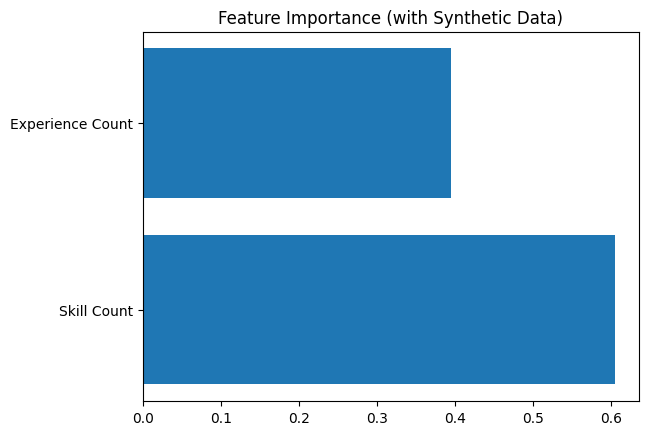

In [3]:
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from textblob import TextBlob
import random


# === 1. Load pre-processed CSV ===
df = pd.read_csv("/content/linkedin_processed_profiles.csv")

lead_types = ['AI', 'Technical', 'HR', 'Decision Maker']
new_rows = []

for _ in range(100):
    sc = random.randint(2, 10)
    ec = random.randint(1, 5)
    lt = random.choice(lead_types)
    new_rows.append({'skill_count': sc, 'exp_count': ec, 'lead_type_code': lead_types.index(lt)})

synthetic_df = pd.DataFrame(new_rows)
X = synthetic_df[['skill_count', 'exp_count']]
y = synthetic_df['lead_type_code']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Feature importance
import matplotlib.pyplot as plt
importances = model.feature_importances_
plt.barh(['Skill Count', 'Experience Count'], importances)
plt.title("Feature Importance (with Synthetic Data)")
plt.show()


In [4]:

# 4. DATA PIPELINE SIMULATION
print("\n🔄 Simulating Data Sync & Deduplication...")

# Simulated new data pull
new_data = df.sample(2).copy()
new_data.iloc[0, 0] = "New Lead A"
new_data.iloc[1, 0] = "New Lead B"

# Deduplication based on Name
combined_df = pd.concat([df, new_data])
deduplicated_df = combined_df.drop_duplicates(subset=["Name"], keep="first")

print(f"Original rows: {len(df)}, After merge: {len(combined_df)}, After deduplication: {len(deduplicated_df)}")


🔄 Simulating Data Sync & Deduplication...
Original rows: 7, After merge: 9, After deduplication: 9


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_pca.py:648: RuntimeWarning: invalid value encountered in divide
  explained_variance_ratio_ = explained_variance_ / total_var


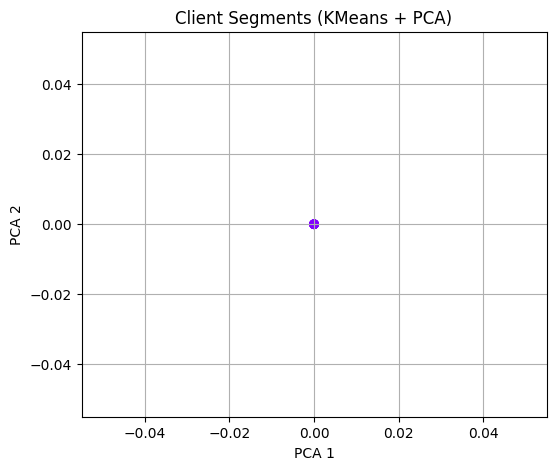

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import ast

# Convert string representations of lists into real lists
df['Skills'] = df['Skills'].apply(ast.literal_eval)
df['Experience'] = df['Experience'].apply(ast.literal_eval)

# Now apply len()
df['skill_count'] = df['Skills'].apply(len)
df['exp_count'] = df['Experience'].apply(len)

# Step 2: Features for clustering
cluster_features = df[['skill_count', 'exp_count']]

# Step 3: KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=0)
df['Cluster'] = kmeans.fit_predict(cluster_features)

# Step 4: Visualization using PCA
pca = PCA(n_components=2)
components = pca.fit_transform(cluster_features)

plt.figure(figsize=(6, 5))
plt.scatter(components[:, 0], components[:, 1], c=df['Cluster'], cmap='rainbow')
plt.title("Client Segments (KMeans + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()


In [6]:
#  6. SENTIMENT ANALYSIS ON EMAILS
print("\n Analyzing Sentiment of Generated Emails...")

def get_sentiment(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['Email Sentiment'] = df['Generated Email'].apply(get_sentiment)

# Print sentiment counts
print(df['Email Sentiment'].value_counts())

# Save updated file
df.to_csv("/content/final_linkedin_analysis.csv", index=False)
print("Final file saved as: /content/final_linkedin_analysis.csv")


 Analyzing Sentiment of Generated Emails...
Email Sentiment
Positive    6
Neutral     1
Name: count, dtype: int64
Final file saved as: /content/final_linkedin_analysis.csv
